# <b>Project: <u>Urban Mobility Optimization: Predicting City-Wide Bike Sharing Demand</u></b>

## <b><u>Problem</u>:</b> If a <u>Bike sharing company</u> runs out of Bikes, during a rush hour the company faces a loss of customers and money!If a station has too many bikes, you can't park new ones.
## <b><u>Our Goal:</u></b> Predict exactly how many bikes will be rented in the next hour based on the time, weather, and holiday status. This allows the logistics team to move bikes around before shortages happen.

## <b>1.Importing Useful Libraries</b>

In [2]:
# Data Handling Tools
import pandas as pd
import numpy as np
import missingno as msno

# Data Visualization Tools
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly.subplots import make_subplots
from IPython.display import display,Markdown
from tabulate import tabulate

# Utilities
import warnings
warnings.filterwarnings('ignore')
import joblib

# Stats models
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Importing ML Models
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.preprocessing import OneHotEncoder,StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor


## <b>2.Loading the Data</b>

In [3]:
df = pd.read_csv('SeoulBikeData.csv',encoding='latin1')
df.head()

,Date,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day
0,01/12/2017,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
1,01/12/2017,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
2,01/12/2017,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes
3,01/12/2017,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
4,01/12/2017,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,Yes


## **3.Data Info**

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Date                       8760 non-null   object 
 1   Rented Bike Count          8760 non-null   int64  
 2   Hour                       8760 non-null   int64  
 3   Temperature(°C)            8760 non-null   float64
 4   Humidity(%)                8760 non-null   int64  
 5   Wind speed (m/s)           8760 non-null   float64
 6   Visibility (10m)           8760 non-null   int64  
 7   Dew point temperature(°C)  8760 non-null   float64
 8   Solar Radiation (MJ/m2)    8760 non-null   float64
 9   Rainfall(mm)               8760 non-null   float64
 10  Snowfall (cm)              8760 non-null   float64
 11  Seasons                    8760 non-null   object 
 12  Holiday                    8760 non-null   object 
 13  Functioning Day            8760 non-null   objec

## **4.Data Description**

In [5]:
print('=============================== Data Description ===============================')
df.describe()

=============================== Data Description ===============================


,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm)
count,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000
mean,704.602055,11.500000,12.882922,58.226256,1.724909,1436.825799,4.073813,0.569111,0.148687,0.075068
std,644.997468,6.922582,11.944825,20.362413,1.036300,608.298712,13.060369,0.868746,1.128193,0.436746
min,0.000000,0.000000,-17.800000,0.000000,0.000000,27.000000,-30.600000,0.000000,0.000000,0.000000
25%,191.000000,5.750000,3.500000,42.000000,0.900000,940.000000,-4.700000,0.000000,0.000000,0.000000
50%,504.500000,11.500000,13.700000,57.000000,1.500000,1698.000000,5.100000,0.010000,0.000000,0.000000
75%,1065.250000,17.250000,22.500000,74.000000,2.300000,2000.000000,14.800000,0.930000,0.000000,0.000000
max,3556.000000,23.000000,39.400000,98.000000,7.400000,2000.000000,27.200000,3.520000,35.000000,8.800000


## **5.Data Cleaning & Transformation**

In [6]:
print('--------------- Unique Values in the Categorical Columns ---------------')
for col in df.select_dtypes(include='object').columns.drop('Date'):
  print(f'{col}:{df[col].unique()}')

--------------- Unique Values in the Categorical Columns ---------------
Seasons:['Winter' 'Spring' 'Summer' 'Autumn']
Holiday:['No Holiday' 'Holiday']
Functioning Day:['Yes' 'No']


### Renaming the Column names

In [7]:
df.columns = ['Date','Rented_Bike_Count','Hour','Temperature','Humidity','Wind_Speed','Visibilty',
              'Dew_Point_Temperature','Solar_Radiation','Rainfall','Snowfall','Seasons','Holiday','Functioning_Day']

In [8]:
df.columns

Index(['Date', 'Rented_Bike_Count', 'Hour', 'Temperature', 'Humidity',
       'Wind_Speed', 'Visibilty', 'Dew_Point_Temperature', 'Solar_Radiation',
       'Rainfall', 'Snowfall', 'Seasons', 'Holiday', 'Functioning_Day'],
      dtype='object')

### Converting `Date (Object)` to `Date(Datetime)`

In [9]:
df['Date'] = pd.to_datetime(df['Date'],format = '%d/%m/%Y')

### Hidden Feature Extraction from `Date` Column

In [10]:
df['Month'] = df['Date'].dt.month
df['Year'] = df['Date'].dt.year
df['Weekday'] = df['Date'].dt.day_name()

In [11]:
df.head()

,Date,Rented_Bike_Count,Hour,Temperature,Humidity,Wind_Speed,Visibilty,Dew_Point_Temperature,Solar_Radiation,Rainfall,Snowfall,Seasons,Holiday,Functioning_Day,Month,Year,Weekday
0,2017-12-01,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes,12,2017,Friday
1,2017-12-01,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes,12,2017,Friday
2,2017-12-01,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes,12,2017,Friday
3,2017-12-01,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes,12,2017,Friday
4,2017-12-01,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,Yes,12,2017,Friday


### Mapping the `Holiday` & `Functioning_Day` Column

In [12]:
# Check Unique values for both the columns
print(f'Holiday:{df['Holiday'].unique()}')
print(f'Functioning Day:{df['Functioning_Day'].unique()}')

Holiday:['No Holiday' 'Holiday']
Functioning Day:['Yes' 'No']


In [13]:
df['Holiday'] = df['Holiday'].map({'No Holiday':0,'Holiday':1})
df['Functioning_Day'] = df['Functioning_Day'].map({'No':0,'Yes':1})

### Dropping the `Date` Column

In [14]:
df.drop(columns = 'Date',inplace = True)
df.head()

,Rented_Bike_Count,Hour,Temperature,Humidity,Wind_Speed,Visibilty,Dew_Point_Temperature,Solar_Radiation,Rainfall,Snowfall,Seasons,Holiday,Functioning_Day,Month,Year,Weekday
0,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,0,1,12,2017,Friday
1,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,0,1,12,2017,Friday
2,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,0,1,12,2017,Friday
3,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,0,1,12,2017,Friday
4,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,0,1,12,2017,Friday


## **6.Data Visualization**

### **Column Description**
`Rented_Bike_Count` shows the count of Bikes rented per day
`Hour`,`Temperature`,`Humidity`,`Wind_Speed`, `Visibility`,`Dew_Point_Temperature`,`Solar_Radiation`,`Rainfall`,`Snowfall`,`Seasons`,`Holiday`,`Functioning_Day`,`Month`,`Year`,`Weekday` are self Explanatory

## **1.Rented Bikes Count**

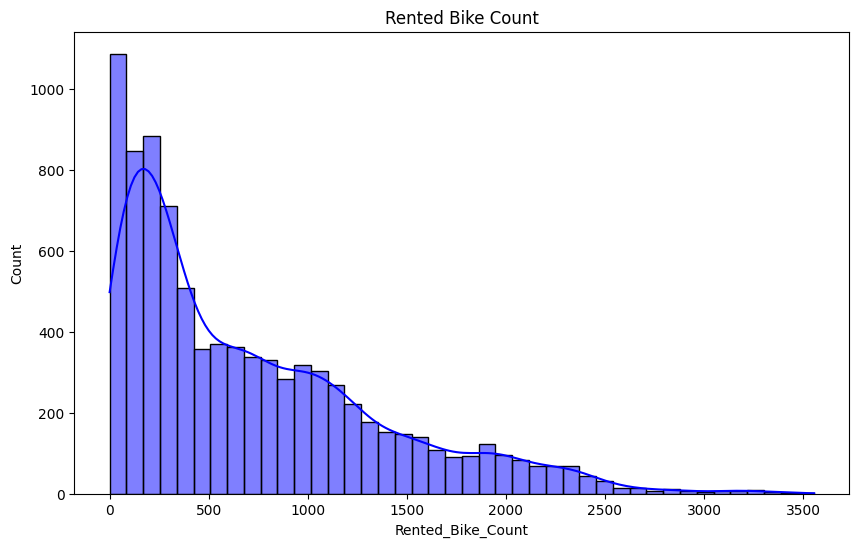

In [15]:
plt.figure(figsize = (10,6))
sns.histplot(df['Rented_Bike_Count'],kde = True,color = 'blue')
plt.title('Rented Bike Count')
plt.show()

### **Insights :**

- By observations the plot shows that the data is **Right Skewed** and it explains that there is an average demand (200 to 500) during the **peak** hours.
- The **long tail** at the right side shows the demand of bikes is rarely high mostly for few hours or a day on some critical high demand.
- There is need to apply **log transformation** to this column to normalize it so that it gives equal importance to both and to predict the busy rush hours and quite nights.

## **2.Average Bike Demands Per Hour**

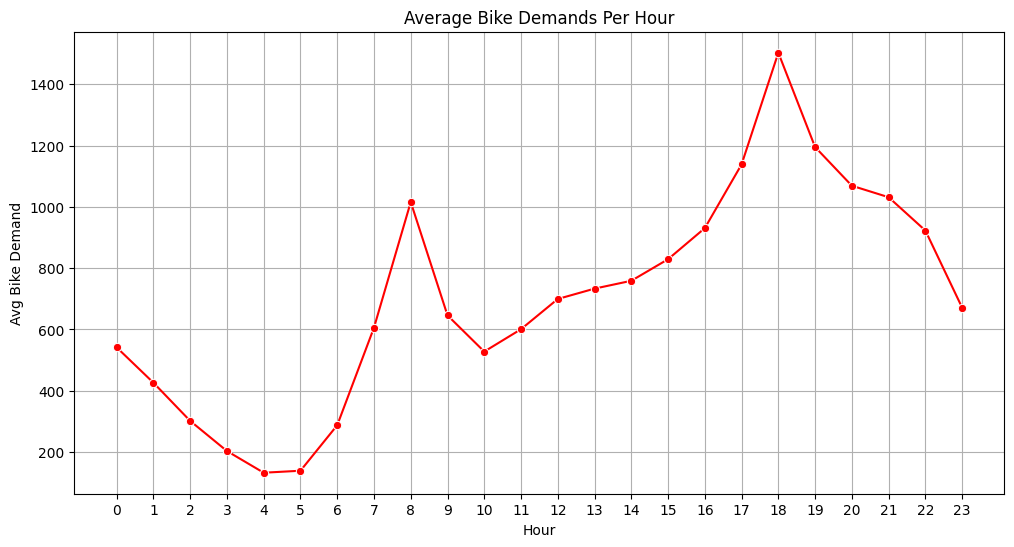

In [16]:
hourly_demands = df.groupby('Hour')['Rented_Bike_Count'].mean().reset_index()

plt.figure(figsize = (12,6))
sns.lineplot(x = 'Hour',y = 'Rented_Bike_Count', data = hourly_demands, marker = 'o',color = 'red')
plt.title('Average Bike Demands Per Hour')
plt.xlabel('Hour')
plt.ylabel('Avg Bike Demand')
plt.grid(True)
plt.xticks(range(0,24))
plt.show()

### **Insights :**

- **Bimodal Distribution:** The data shows a clear bimodal pattern (two distinct peaks), indicating that bike usage is heavily driven by commuter traffic.

- **Morning Rush (Start of Business):** There is a sharp spike in demand between 6 AM and 9 AM (reaching ~1000 rentals). This correlates with people commuting to work and school.

- **Evening Rush (End of Business):** The demand surges to its highest point (peak > 1500) during the 6 PM to 10 PM window. This suggests a combination of people returning home from work plus evening leisure activities (gym, dinner, etc.).

- **Off-Peak Lull:** Demand drops significantly after midnight (down to 400-600) and remains moderate during working afternoon hours, further confirming the "rush hour" hypothesis.

- **Here the Evening Rush is Higher than the Morning Rush Why?:** Because in evening many people have their free time for GYM, Class, Travel, Shopping or else + Return from Work & Business

## **3.Effect Of Temperature on Bike Demands**

In [17]:
fig = px.scatter(
  df,
  x = 'Hour',
  y = 'Rented_Bike_Count',
  color = 'Temperature',
  color_continuous_scale='RdBu_r',
  title = '<b>Effect Of Time & Temperature On Bike Demand</b>',
  opacity = 0.5,
  labels = {'Rented_Bike_Count':'Rented Bike Count','Hour':'Hour Of Day'}
)
fig.update_layout(
  title_x = 0.5,
  height = 600,
  xaxis = dict(tickmode = 'linear',dtick = 1),
  plot_bgcolor = 'white'
)

fig.show()

### **Insights:**

- Here this graph shows the peak times of 6am and 8pm for the **Bike Demand** even when there is **low and high temperature**.
- This scatter plot perfectly shows the effect temperature is there which affects the bike demand even during the peak demand hours.
- When there is a **low temperature** often at peak hours too the **Bike demand is low** and the **high temperature** does not seems to be affecting the bike demand during the peak hours, but it has affected during **the afternoon** time and the **demand** is found to be **less**.

## **4.Heatmap: Average Bike Demand by Hour and Temperature**

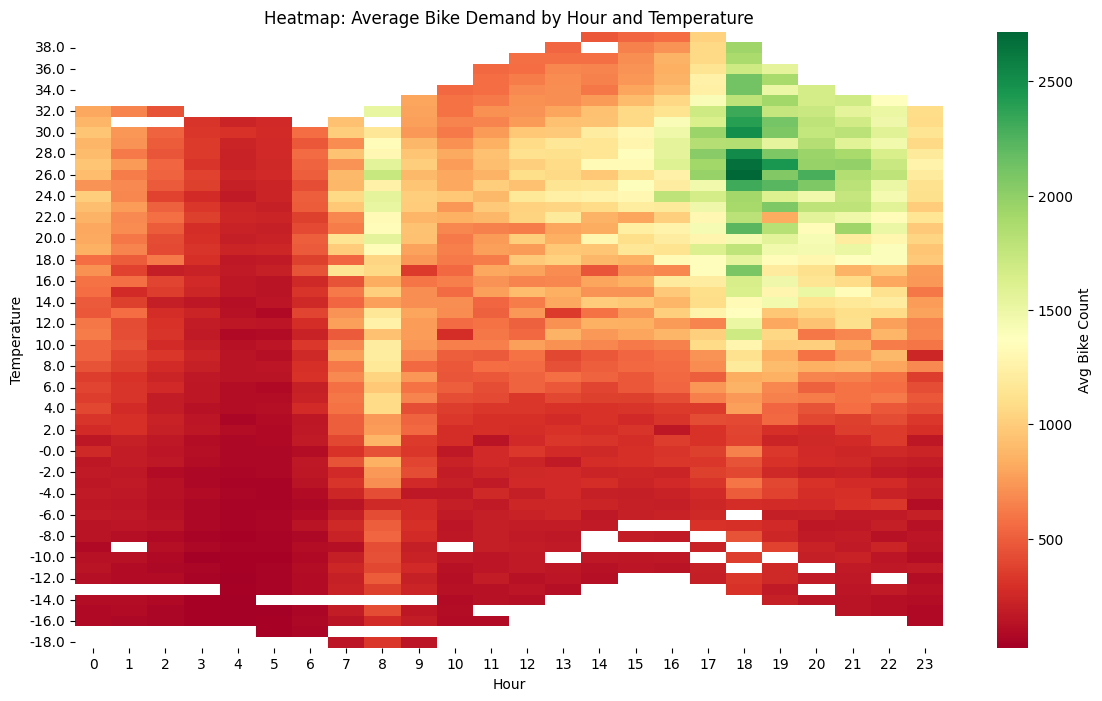

In [18]:
df['Temp_rounded'] = df['Temperature'].round()

heatmap_data = df.pivot_table(index = 'Temp_rounded',columns = 'Hour',values = 'Rented_Bike_Count',aggfunc = 'mean')

plt.figure(figsize = (14,8))
sns.heatmap(heatmap_data,cmap = 'RdYlGn',cbar_kws ={'label':'Avg Bike Count'})
plt.title('Heatmap: Average Bike Demand by Hour and Temperature')
plt.xlabel('Hour')
plt.ylabel('Temperature')
plt.gca().invert_yaxis() # Put high temps at the top
plt.show()

### **Insights:**

- The two **vertical bands** of peak hours clearly shows the demand of bike even when the **temperature** is **not perfect** and it's because people have to go for their work.
- The **perfect demand spot** during 4pm to 8pm at afternoon/night there is as usual high demand with average temperature(20°C - 25°C).
- The **Danger zones** for the low demand are the **bottom area** with **low temperature(-18°C to 6°C)** with **low demand** and the **top area** with **extreme temperature >35°C** has a **low demand**.

## **5.Relation Of Bike Demand with other Numerical Columns**

In [19]:
df.columns

Index(['Rented_Bike_Count', 'Hour', 'Temperature', 'Humidity', 'Wind_Speed',
       'Visibilty', 'Dew_Point_Temperature', 'Solar_Radiation', 'Rainfall',
       'Snowfall', 'Seasons', 'Holiday', 'Functioning_Day', 'Month', 'Year',
       'Weekday', 'Temp_rounded'],
      dtype='object')

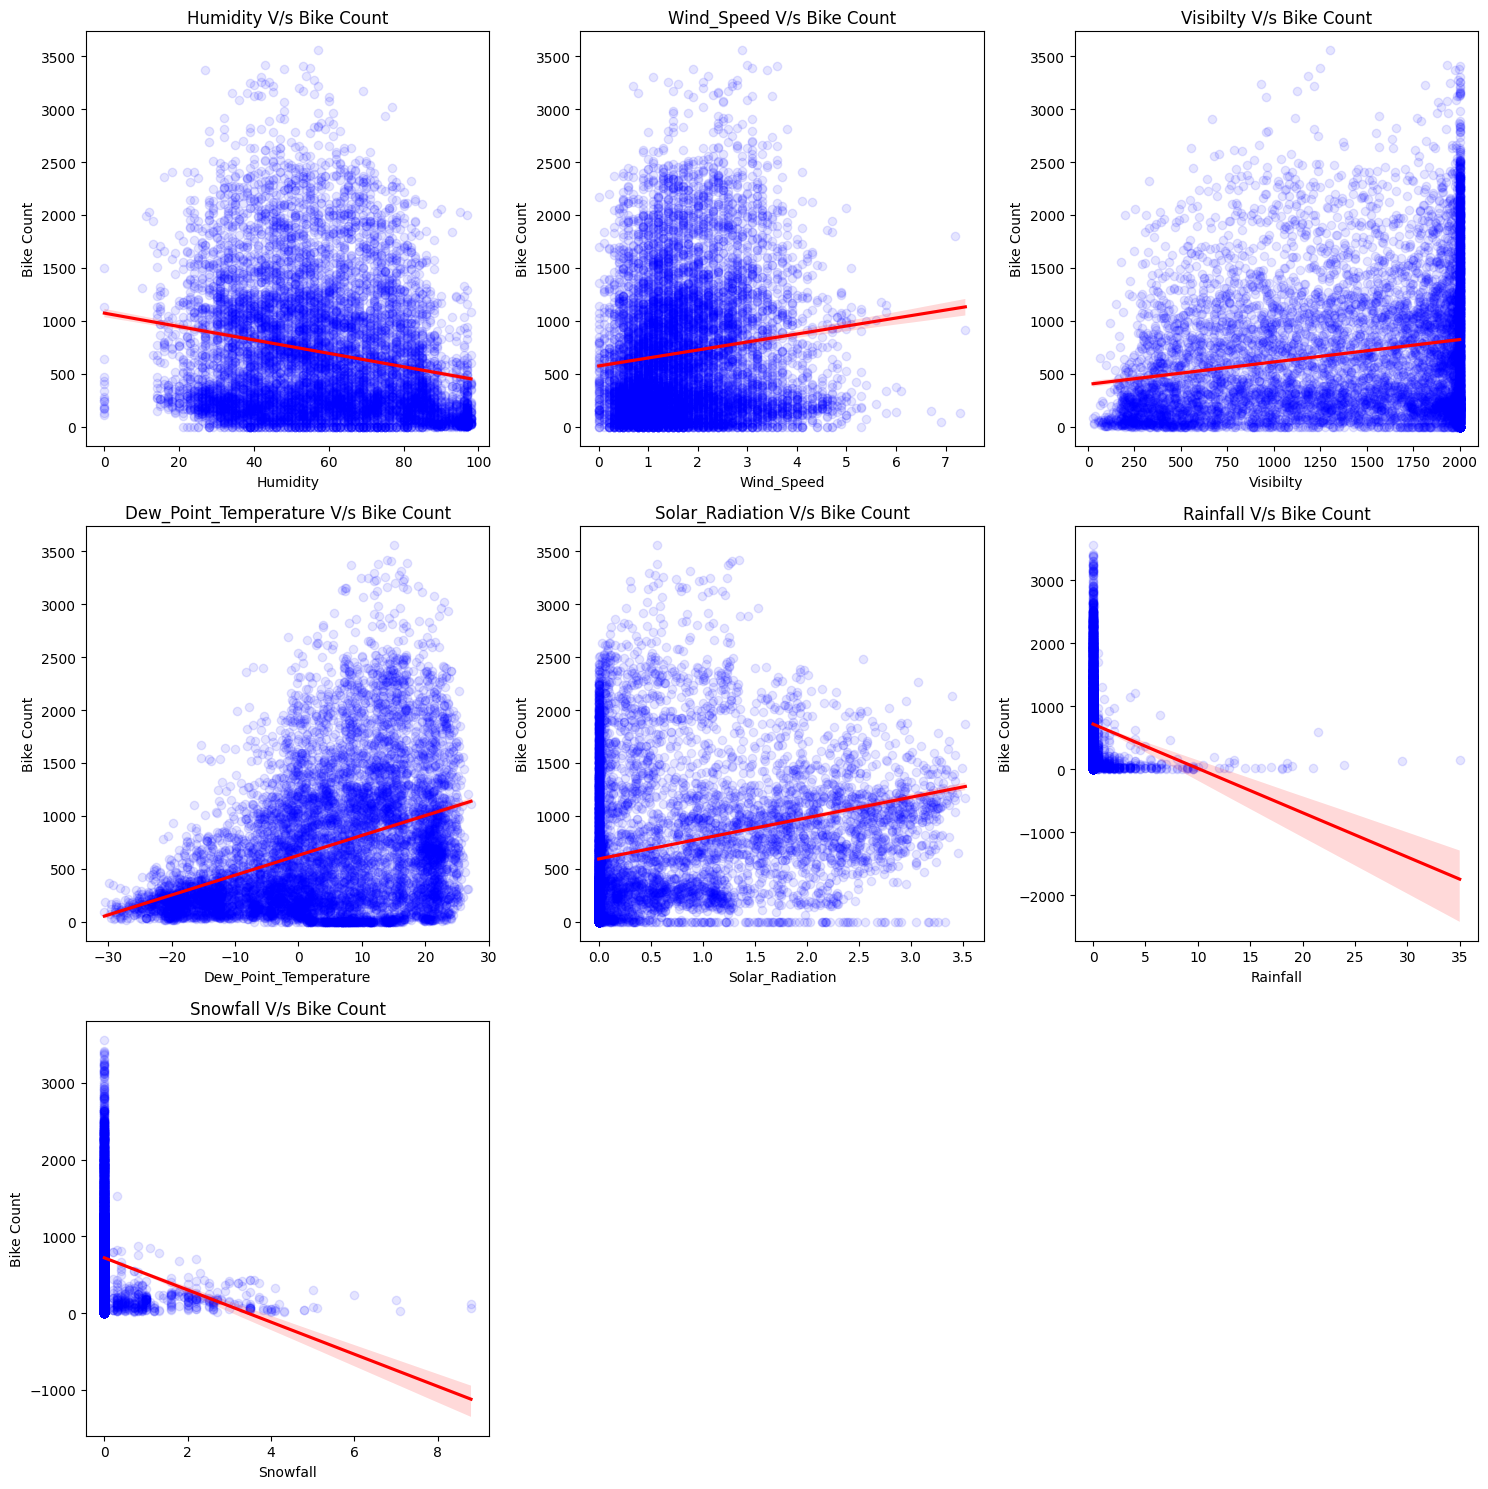

In [20]:
features = ['Humidity', 'Wind_Speed','Visibilty', 'Dew_Point_Temperature', 'Solar_Radiation', 'Rainfall','Snowfall']

plt.figure(figsize = (15,15))

for i , col in enumerate(features):
  plt.subplot(3,3,i+1)
  sns.regplot(x = col,
              y = 'Rented_Bike_Count',
              data = df,
              scatter_kws ={'alpha':0.1,'color' : 'blue'},
              line_kws = {'color':'red'}
              )
  plt.title(f'{col} V/s Bike Count')
  plt.xlabel(f'{col}')
  plt.ylabel('Bike Count')

plt.tight_layout()
plt.show()


### **Insights:**

- **1.Humidity:** It shows when the humidity is too low it means there is a low demand of bikes during dry day and also when there is high humidity the demand drops little bit and meanwhile the demand is higher during average humidity.
- **2.Rainfall/Snowfall:** These are the strong factors affecting the demand.Even if there is a rise in rainfall/snowfall the demand for the bikes instantly drops and this shows the negative relation.
- **3.Solar Radiation:** The graph of solar radiation shows a positive trend and this means people love biking during the sunny days.
- **4.Wind Speed:** The more speedy winds drops the bike demands and on the other hand the days with low wind speed has high bike demands.
- **5.Visibility:** The graph shows that people demand more on the clearer days.It also shows a small positive trend.
- **6.Dew Point Temperature:** It shows a high positive trend where people demand more during the high dew point temperature and there is a low demand when ever there is a low dew point temperature.

## **6.Avg Bike Demand - Season Wise**

In [21]:
seasons_data = df.groupby('Seasons')['Rented_Bike_Count'].mean().round().reset_index()
fig = px.bar(
  seasons_data,
  x = 'Seasons',
  y = 'Rented_Bike_Count',
  color = 'Seasons',
  title = "<b>Avg Bike Demand In Different Seasons</b>",
  text = 'Rented_Bike_Count'
)
fig.update_traces(textposition = 'outside')
fig.update_layout(
  width = 700,
  height = 600,
  title_x = 0.5,
  xaxis_title = 'Seasons',
  yaxis_title = 'Avg Bike Demand',
  showlegend = False,
  bargap = 0.2,
  plot_bgcolor = 'white',
  font = dict(size = 13)
)
fig.show()

### **Insights:**

- This bar graph clearly shows the demand of Bikes in each seasons, where **people love** to **ride more on bikes** in the **summer season**.
- Meanwhile **autumn and spring** also has an **average demand** and the **lowest demand** can be seen as **winter season**, the **reason** behind the low demand in winter season could be due to **low temperature** and **low visibility** due to **low dew point temperature**.

## **7.Holiday Analysis**

In [22]:
# -------- Holiday Analysis --------
holiday_avg = df.groupby('Holiday')['Rented_Bike_Count'].mean().round().reset_index()

holiday_avg['Holiday'] = holiday_avg['Holiday'].map({0:'No Holiday',1:'Holiday'})
fig = px.bar(
  holiday_avg,
  x = 'Holiday',
  y = 'Rented_Bike_Count',
  color = 'Holiday',
  title = '<b>Avg Bike Demand: Holiday Vs No Holiday</b>',
  text = 'Rented_Bike_Count'
)
fig.update_traces(textposition = 'outside')
fig.update_layout(
  title_x = 0.5,
  width = 700,
  height = 600,
  xaxis_title = 'Holiday',
  yaxis_title = 'Avg Bike Demand',
  bargap = 0.2,
  plot_bgcolor = 'white',
  font = dict(size = 14),
  # showlegend = True
)
fig.show()

fig1 = px.box(
  df,
  x = 'Holiday',
  y = 'Rented_Bike_Count',
  color = 'Holiday',
  title = '<b>Distribution of Bike Demand on Holidays</b>',
  points = 'outliers'

)
fig1.update_layout(
  title_x = 0.5
)
fig1.show()


### **Insights:**

- The **average demand** on holidays is **likely lower** than **Non-Holidays**.This reinforces the hypothesis that the system is **primarily used** by **workers for commuting,** rather than just tourists.
- The **median value** on **holidays** is **low** as compared to the median value of Non-Holidays, while boxplot shows **significant outliers(high usage)**.This suggests that on specifice **nice holidays** the **demand** can still **spike** and thus not all holidays should be treated as **'low demand days'**.

## **8.Functioning Day Analysis**

In [23]:
# -------- Holiday Analysis --------
function_day_avg = df.groupby('Functioning_Day')['Rented_Bike_Count'].mean().round().reset_index()

function_day_avg['Functioning_Day'] = function_day_avg['Functioning_Day'].map({0:'No ',1:'Yes'})

fig = px.bar(
  function_day_avg,
  x = 'Functioning_Day',
  y = 'Rented_Bike_Count',
  color = 'Functioning_Day',
  title = '<b>Avg Bike Demand: Functioning_Day Vs No Functioning_Day</b>',
  text = 'Rented_Bike_Count'
)
fig.update_traces(textposition = 'outside')
fig.update_layout(
  title_x = 0.5,
  width = 700,
  height = 600,
  xaxis_title = 'Functioning Day',
  yaxis_title = 'Avg Bike Demand',
  bargap = 0.2,
  plot_bgcolor = 'white',
  font = dict(size = 14),
  # showlegend = True
)
fig.show()

### **Insights:**

- As expected when there is Non-Functioning Day the demand is exactly 0.This confirms the data integrity.(If not 0 it means there is an error in data.)
- It means in further steps we need to remove those rows with no functioning day and then all values of functioning day will be 1 so there is no use of functioning_day columns so we will drop it later

## **9.Month Wise Demands Of Bike Rental**

In [24]:
# -------- Month Wise Analysis --------
monthly_avg = df.groupby('Month')['Rented_Bike_Count'].mean().round().reset_index()

fig = px.bar(
  monthly_avg,
  x = 'Month',
  y = 'Rented_Bike_Count',
  color = 'Month',
  title = '<b>Avg Bike Demand:Month Wise</b>',
  text = 'Rented_Bike_Count'
)
fig.update_traces(textposition = 'outside')
fig.update_layout(
  title_x = 0.5,
  width = 1000,
  height = 600,
  xaxis_title = 'Month',
  yaxis_title = 'Avg Bike Demand',
  bargap = 0.2,
  plot_bgcolor = 'white',
  font = dict(size = 14)
)
fig.show()

### **Insights:**

- As expected the plot shows a **"Bell Curve"** Shaped bar graph.
- The data shows **strong seasonality**.Demand **peaks** in **May/June/July/August** due to **Warm(Summer)** season, while January has the **lowest demand** due to snow/cold in the **Winter** season.
- This suggests we need **different strategies** for the **Summer Vs Winter seasons**.

## **10.Weekday: Commuters Vs. Leisure**

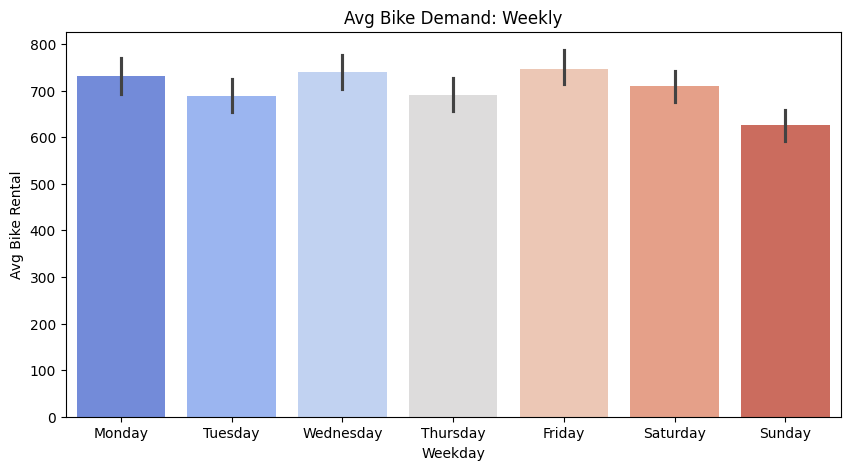

In [25]:
day_order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']

plt.figure(figsize = (10,5))
sns.barplot(x = 'Weekday',y = 'Rented_Bike_Count',data = df,order = day_order,palette = 'coolwarm')
plt.title('Avg Bike Demand: Weekly')
plt.xlabel('Weekday')
plt.ylabel('Avg Bike Rental')
plt.show()

### **Insights:**

- The analysis reveals that the **weekdays** have often **higher** **Demand** Average for the Bike Rentals as compared to weekends, confirming that the **primary use case** for this Bike system is **workplace commuting**.
- But the **weekends** have only **slightly low demand** as compared to weekdays, because people often take Bike rentals for **travel,fun** and to** enjoy their **weekends**, so **weekends** should not be *conisdered* as most **lower demanding days**.

## **11.Year Analysis: Showing the growth trend**

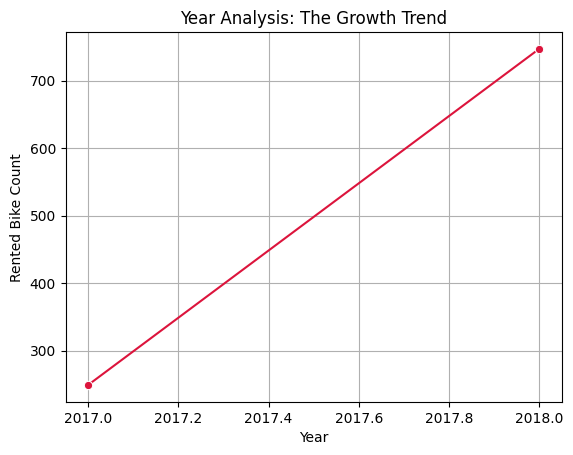

In [26]:
yearly_avg = df.groupby('Year')['Rented_Bike_Count'].mean().round().reset_index()

sns.lineplot(x = 'Year',y = 'Rented_Bike_Count',data = yearly_avg,color = 'crimson',marker = 'o')
plt.title('Year Analysis: The Growth Trend')
plt.xlabel('Year')
plt.ylabel('Rented Bike Count')
plt.grid(True)
plt.show()

### **Insights:**
- The lineplot clearly shows and expalins the **Growth Trend** of the Company over the last two year from **2017 (249) to 2018 (747)**.
- This shows a **YOY(Year Over Year) growth** and the importance of Bike rentals and it's demand over the years.

## **12.Weekday Vs Weekend**

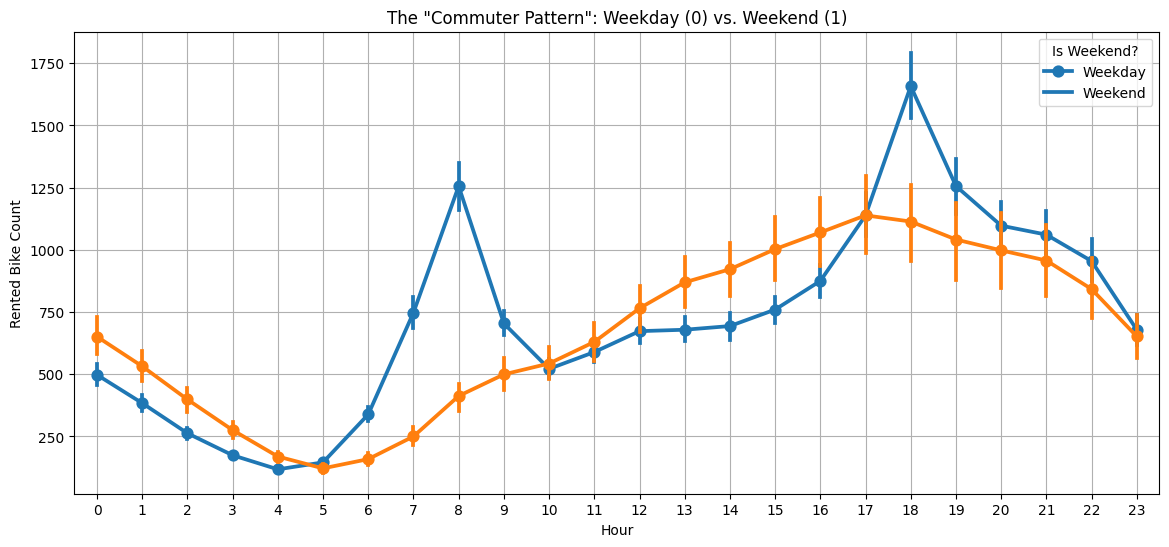

In [27]:
plt.figure(figsize=(14, 6))

# Plot 'Hour' on X, 'Count' on Y, but split the lines by 'Weekday' (or better, just Weekday vs Weekend)
# Let's create a simple 'Is_Weekend' feature for this plot
df['Is_Weekend'] = df['Weekday'].apply(lambda x: 1 if x in ['Saturday', 'Sunday'] else 0)

sns.pointplot(x='Hour', y='Rented_Bike_Count', hue='Is_Weekend', data=df)
plt.title('The "Commuter Pattern": Weekday (0) vs. Weekend (1)')
plt.legend(title='Is Weekend?', labels=['Weekday', 'Weekend'])
plt.ylabel('Rented Bike Count')
plt.grid(True)
plt.show()

### **Insights:**
- Why? The "Rush Hour" (8 AM / 6 PM) usually disappears on weekends!

- **Weekdays:** Two sharp peaks (8 AM, 6 PM).

- **Weekends:** One smooth curve (peaking around 2 PM - 4 PM).

## **7.The "Multicollinearity" Trap (VIF Check)**
### The Problem: We have Temperature and Dew_Point_Temp. We also have Humidity.

### Physics Fact: Dew Point is literally calculated from Temperature and Humidity. They are highly correlated.

### So feeding two identical features into a model (especially Linear Regression), it gets confused about which one is actually driving the prediction. It inflates the variance (error).

### Solution is to Calculate the Variance Inflation Factor (VIF). If VIF > 10, drop that feature.

In [28]:
numeric_cols = df.select_dtypes(include = ['float64','int64']).columns.tolist()
numeric_cols = [col for col in numeric_cols if col not in ['Rented_Bike_Count']]

vif_data = pd.DataFrame()
vif_data['Feature'] = numeric_cols
vif_data['VIF'] = [variance_inflation_factor(df[numeric_cols].values,i) for i in range(len(numeric_cols ))]
print(vif_data.sort_values(by = 'VIF',ascending = False))

                  Feature          VIF
1             Temperature  3660.171421
11           Temp_rounded  3622.378147
10        Functioning_Day    27.858315
5   Dew_Point_Temperature    25.790118
2                Humidity    18.140535
4               Visibilty     9.144240
3              Wind_Speed     4.811202
0                    Hour     4.421569
6         Solar_Radiation     2.884743
12             Is_Weekend     1.412346
8                Snowfall     1.121758
7                Rainfall     1.083094
9                 Holiday     1.058854


### Here the Temp_Rounded is same as Temperature and then Dew_Point_Temperature can be calculated by temperature and humidity so we will drop these two and about Functioning_Day there is no need of this column because when Functioning_Day is 0 the Bike Rental Demand is exactly 0 so it just adds a noise in the data for our models.

In [29]:
# --- Keeping only those rows where the system is working (1) ---
df_clean = df[df['Functioning_Day'] == 1].copy()

# --- Now dropping the other columns which is not is use --- 
df_model = df_clean.drop(columns=['Temp_rounded', 'Functioning_Day', 'Dew_Point_Temperature'], axis=1)

print(f"Original shape: {df.shape}")
print(f"Shape after filtering closed days: {df_model.shape}")

Original shape: (8760, 18)
Shape after filtering closed days: (8465, 15)


In [30]:
numeric_cols = df_model.select_dtypes(include = ['float64','int64']).columns.tolist()
numeric_cols = [col for col in numeric_cols if col not in ['Rented_Bike_Count']]

vif_data = pd.DataFrame()
vif_data['Feature'] = numeric_cols
vif_data['VIF'] = [variance_inflation_factor(df[numeric_cols].values,i) for i in range(len(numeric_cols ))]
print(vif_data.sort_values(by = 'VIF',ascending = False))

           Feature       VIF
2         Humidity  5.029042
4        Visibilty  4.760153
3       Wind_Speed  4.610685
0             Hour  3.930839
1      Temperature  3.240247
5  Solar_Radiation  2.255375
9       Is_Weekend  1.379714
7         Snowfall  1.121140
6         Rainfall  1.079804
8          Holiday  1.055880


In [31]:
print('================= Before Data Preprocessing ===================')
df_model.head()

================= Before Data Preprocessing ===================


,Rented_Bike_Count,Hour,Temperature,Humidity,Wind_Speed,Visibilty,Solar_Radiation,Rainfall,Snowfall,Seasons,Holiday,Month,Year,Weekday,Is_Weekend
0,254,0,-5.2,37,2.2,2000,0.0,0.0,0.0,Winter,0,12,2017,Friday,0
1,204,1,-5.5,38,0.8,2000,0.0,0.0,0.0,Winter,0,12,2017,Friday,0
2,173,2,-6.0,39,1.0,2000,0.0,0.0,0.0,Winter,0,12,2017,Friday,0
3,107,3,-6.2,40,0.9,2000,0.0,0.0,0.0,Winter,0,12,2017,Friday,0
4,78,4,-6.0,36,2.3,2000,0.0,0.0,0.0,Winter,0,12,2017,Friday,0


## **8.Separating the Data & applying the `train_test_split` to split the data into `X_train,X_test,y_train,y_test`**

In [32]:
# separate the data into X & y
X = df_model.drop('Rented_Bike_Count',axis = 1)
y = df_model['Rented_Bike_Count']

# ---------- applying the train_test_split----------
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2,random_state = 42)

print('X_train Shape:',X_train.shape)
print('X_test Shape:',X_test.shape)
print('y_train Shape:',y_train.shape)
print('y_test Shape:',y_test.shape)

X_train Shape: (6772, 14)
X_test Shape: (1693, 14)
y_train Shape: (6772,)
y_test Shape: (1693,)


In [33]:
X_train.to_csv('X_train.csv')
X_test.to_csv('X_test.csv')
y_test.to_csv('y_test.csv')

## **9.Distribution Of the `X_train` & `X_test`**

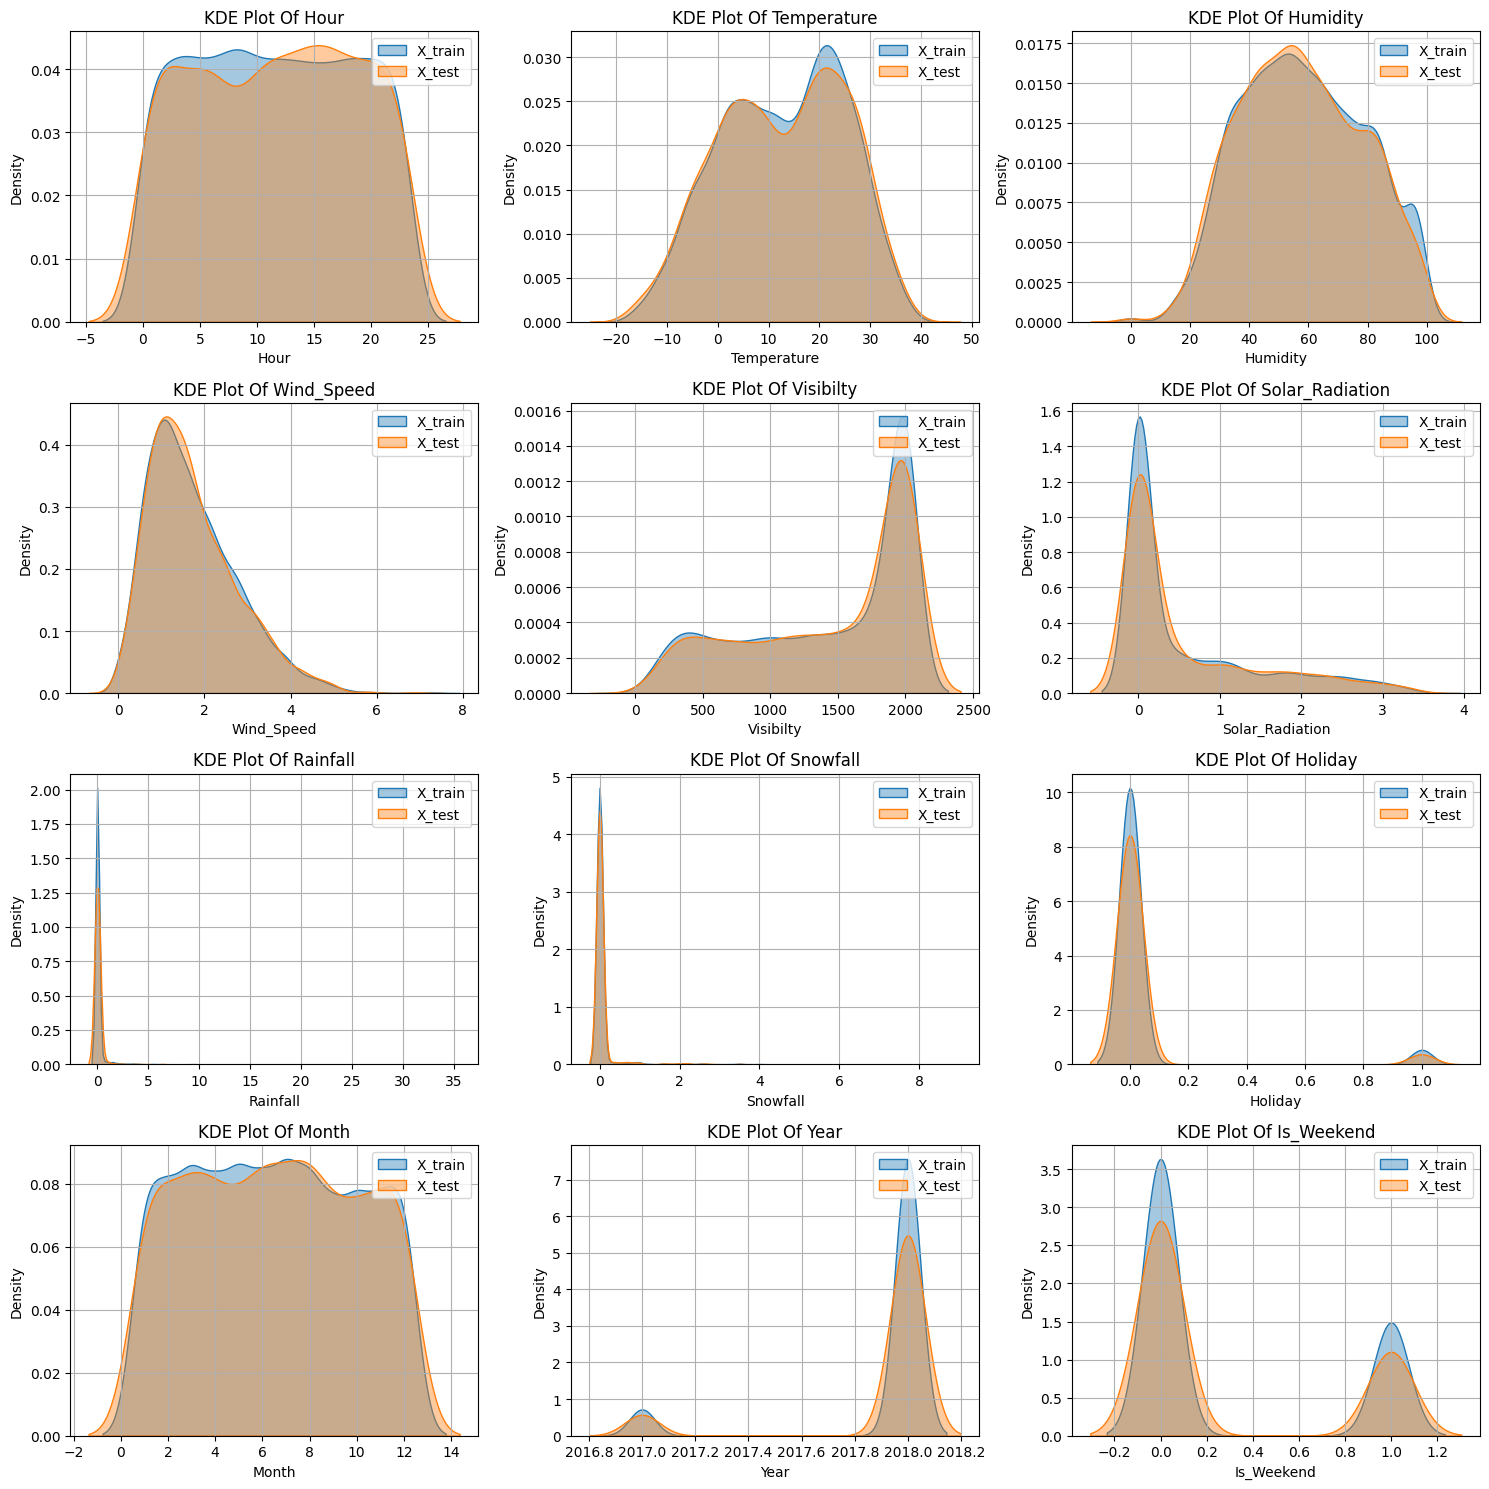

In [34]:
num_features = X.select_dtypes(include = ['float64','int32','int64'])

plt.figure(figsize = (15,15))

for i, col in enumerate(num_features):
  plt.subplot(4,3,i+1)
  sns.kdeplot(X_train[col],fill = True,alpha = 0.4,label = 'X_train')
  sns.kdeplot(X_test[col],fill = True,alpha = 0.4,label = 'X_test')
  plt.title(f'KDE Plot Of {col}')
  plt.xlabel(f'{col}')
  plt.ylabel('Density')
  plt.legend(loc ='upper right')
  plt.grid(True)

plt.tight_layout()
plt.show()


##  **Distribution Of `y_train`,`y_test`**

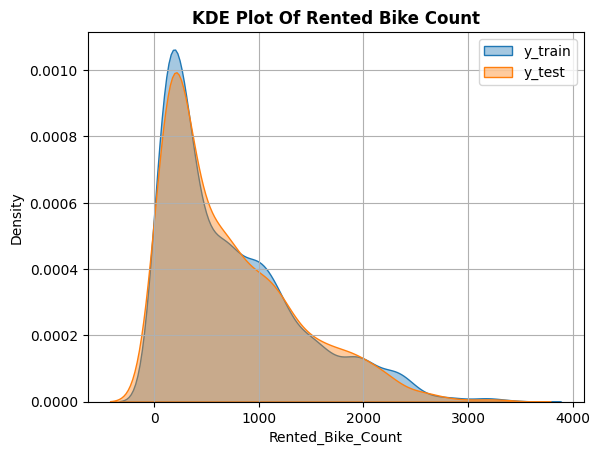

In [35]:
sns.kdeplot(y_train,fill = True,alpha = 0.4,label = 'y_train')
sns.kdeplot(y_test,fill = True,alpha = 0.4,label = 'y_test')

plt.title('KDE Plot Of Rented Bike Count',fontweight = 'bold')
plt.legend(loc = 'upper right')
plt.grid(True)
plt.show()

## **10.Feature Engineering**

### **Why Cyclic Encoding? :**
- We know that in a clock the hour 23 and 0 are close but the models interpret as they are far apart and thus the predictions can be different, since they will not capture the actual relationship in a cyclic featured column
- Same goes for the Weekday column as Sunday is close to monday and same for the months where December and January are close and all they form a cyclic relationship
- Thus we are applying sin & cos functions based on their angle (2 * pi * (value/max_value)) which maps them in the 2D space or coordinate like (cos , sin) where cos gives the x and sin gives the y value 

In [36]:
# ------Function To enocde the hour,weekday and month of year in sin & cos values-------
def cyclic_encode(df,col,max_value):
  df[f'{col}_sin'] = np.sin(2 * np.pi * df[col]/max_value)
  df[f'{col}_cos'] = np.cos(2 * np.pi * df[col]/max_value)

  return df.drop(f'{col}',axis = 1)


In [37]:
# ------ Hour Column Cyclic Encoding -------
X_train = cyclic_encode(X_train,'Hour',24)
X_test = cyclic_encode(X_test,'Hour',24)

In [38]:
# ----- Mapping The Weekday Column -------
weekday_map = {
  'Monday':0,
  'Tuesday':1,
  'Wednesday':2,
  'Thursday':3,
  'Friday':4,
  'Saturday':5,
  'Sunday':6
}

X_train['Weekday'] = X_train['Weekday'].map(weekday_map)
X_test['Weekday'] = X_test['Weekday'].map(weekday_map)



In [39]:
# ------- Weekday Column Cyclic Encoding --------
X_train = cyclic_encode(X_train,'Weekday',7)
X_test = cyclic_encode(X_test,'Weekday',7)

In [40]:
# ------- Month Column Cyclic Encoding --------
X_train = cyclic_encode(X_train,'Month',12)
X_test = cyclic_encode(X_test,'Month',12)


## **11.Correlation Plot**

In [41]:
train_data = X_train.copy() # here using .copy() to not mess with original X_train

categorical_cols = train_data.select_dtypes(include = 'object').columns
# encoding the train_data only
train_data_encoded = pd.DataFrame(
  pd.get_dummies(train_data, columns = categorical_cols, drop_first = True)
)

train_data_encoded['Rented_Bike_Count'] = y_train

corr_matrix = train_data_encoded.corr(numeric_only = True)['Rented_Bike_Count'].drop('Rented_Bike_Count') # taking correlation of training data only to prevent the data leakage)
corr_matrix = pd.DataFrame(corr_matrix).reset_index()
corr_matrix['Rented_Bike_Count'] = corr_matrix['Rented_Bike_Count'].round(3)

plt.figure(figsize = (12,8))
fig = px.bar(
  corr_matrix,
  x = 'Rented_Bike_Count',
  y = 'index',
  color = 'Rented_Bike_Count',
  title = '<b>Correlation Of Features With Bike Rental Count</b>',
  text = 'Rented_Bike_Count'
)
fig.update_layout(
  height = 800,
  width = 1200,
  title_x = 0.5,
  xaxis_title = 'Correlation With Bike Rental Count',
  yaxis_title = 'Features',
  plot_bgcolor = 'white',
  font = dict(size = 14)
)
fig.show()


<Figure size 1200x800 with 0 Axes>

## **12.Data Preprocessing**

In [42]:
# --------- Numerical & Categorial Columns ----------
num_cols = X_train.select_dtypes(include = ['int64','float64','int32']).columns
cat_cols = X_train.select_dtypes(include = ['object']).columns

# --------- Defining Transformer -----------
num_transformer = StandardScaler()
cat_transformer = OneHotEncoder(handle_unknown = 'ignore')

# --------- Combine into column Transformer ----------
preprocessor = ColumnTransformer(
  transformers = [
    ('num',num_transformer,num_cols),
    ('cat',cat_transformer,cat_cols)
  ]
)

## **13.Feature Scaling**

In [43]:
print('Scaling the data....')
X_train_scaled = preprocessor.fit_transform(X_train)
X_test_scaled = preprocessor.transform(X_test)
print('Finished Scaling the Data')

Scaling the data....
Finished Scaling the Data


## **14.Training & Evaluating the Models**

In [44]:
# -------- Function to print the metrics & Actual V/s Predicted plot ---------
results = [] # to store the metrics result

def model_evaluation(model_name,y_pred,save = False):

  # --- Metrics Calculation ---
  r2 = r2_score(y_test,y_pred)
  mse = mean_squared_error(y_test,y_pred)
  mae = mean_absolute_error(y_test,y_pred)

  # --- Save the results ---
  if save == True:
    results.append(
      {
        'Model':model_name,
        'R2_score':r2,
        'MSE':mse,
        'MAE':mae
      }
    )

  print(f'=============={model_name}==============\n'
        f'R2_score: {r2}\n'
        f'MSE: {mse}\n'
        f'MAE: {mae}\n')
  
  plt.figure(figsize = (5,5))

  sns.scatterplot(
    x = y_test,
    y = y_pred,
    alpha = 0.6,
  )
  plt.plot([y_test.min(),y_test.max()],[y_test.min(),y_test.max()],'r--',lw = 2,color = 'red')
  plt.title(f'Regression plot for {model_name}',fontweight = 'bold')
  plt.xlabel('Actual Bike Count')
  plt.ylabel('Predicted Bike Count')
  plt.grid(True)
  plt.show()



==============LinearRegression==============
R2_score: 0.5733890461887544
MSE: 167481.64253183804
MAE: 314.1281843275884



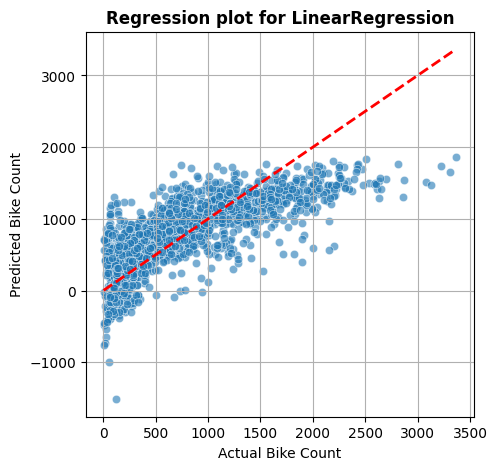

In [45]:
lr = LinearRegression()
lr.fit(X_train_scaled,y_train)
y_pred = lr.predict(X_test_scaled)
model_evaluation('LinearRegression',y_pred,save = True)

==============RidgeRegression==============
R2_score: 0.5734445415331048
MSE: 167459.85581646743
MAE: 314.07383862512114



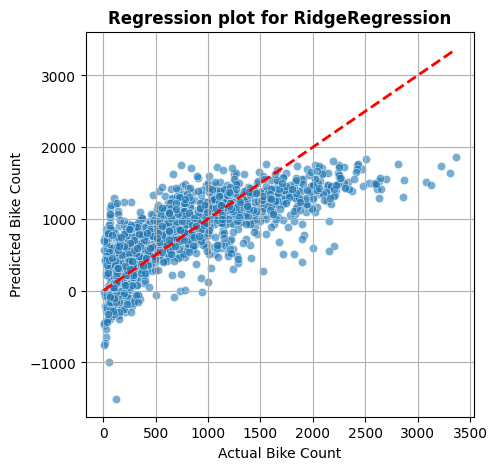

In [46]:
ridge = Ridge()
ridge.fit(X_train_scaled,y_train)
y_pred = ridge.predict(X_test_scaled)
model_evaluation('RidgeRegression',y_pred,save = True)

==============LassoRegression==============
R2_score: 0.5743004176059222
MSE: 167123.85054234456
MAE: 312.6813654963955



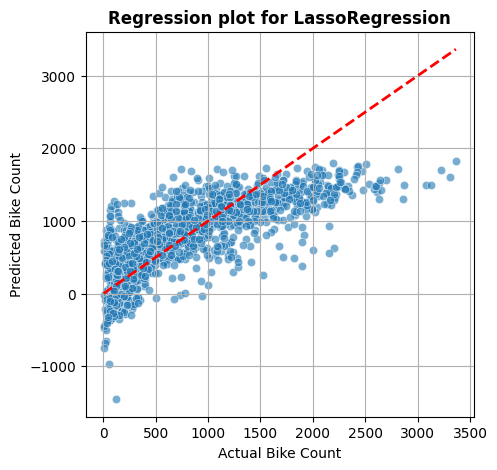

In [47]:
lasso = Lasso()
lasso.fit(X_train_scaled,y_train)
y_pred = lasso.predict(X_test_scaled)
model_evaluation('LassoRegression',y_pred,save = True)

==============DecisionTreeRegression==============
R2_score: 0.8527835602599733
MSE: 57795.16656822209
MAE: 133.99704666272888



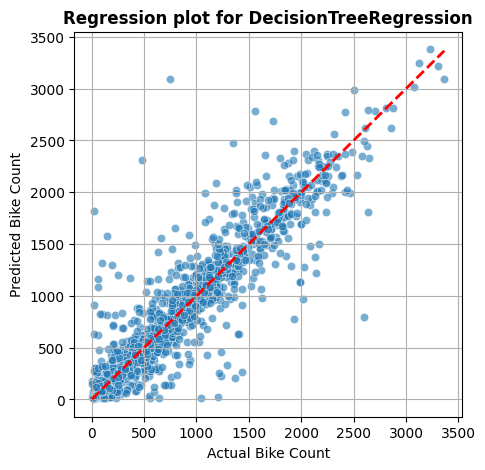

In [48]:
dt = DecisionTreeRegressor()
dt.fit(X_train_scaled,y_train)
y_pred = dt.predict(X_test_scaled)
model_evaluation('DecisionTreeRegression',y_pred,save = True)

==============RandomForestRegressor==============
R2_score: 0.9228533981544499
MSE: 30286.703792793858
MAE: 95.24580035440049



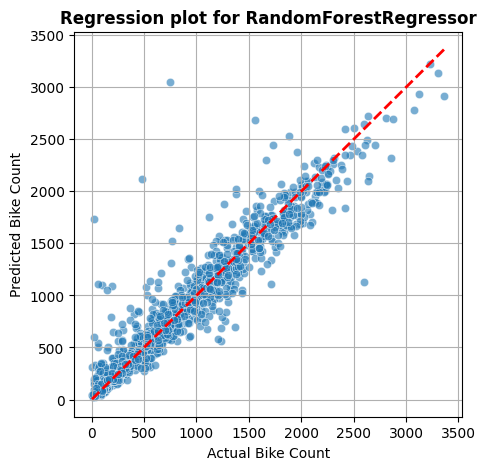

In [49]:
rf = RandomForestRegressor()
rf.fit(X_train_scaled,y_train)
y_pred = rf.predict(X_test_scaled)
model_evaluation('RandomForestRegressor',y_pred,save = True)

==============XGBRegressor==============
R2_score: 0.9254655838012695
MSE: 29261.193359375
MAE: 96.8246078491211



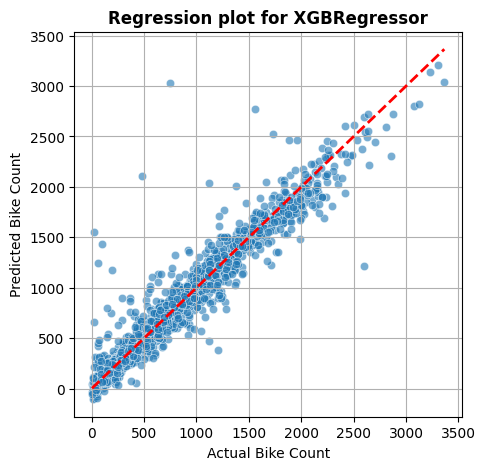

In [50]:
xgb = XGBRegressor()
xgb.fit(X_train_scaled,y_train)
y_pred = xgb.predict(X_test_scaled)
model_evaluation('XGBRegressor',y_pred,save = True)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015738 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1055
[LightGBM] [Info] Number of data points in the train set: 6772, number of used features: 20
[LightGBM] [Info] Start training from score 731.390431
==============LGBMRegressor==============
R2_score: 0.9294025797778525
MSE: 27715.584402333738
MAE: 90.84252147520729



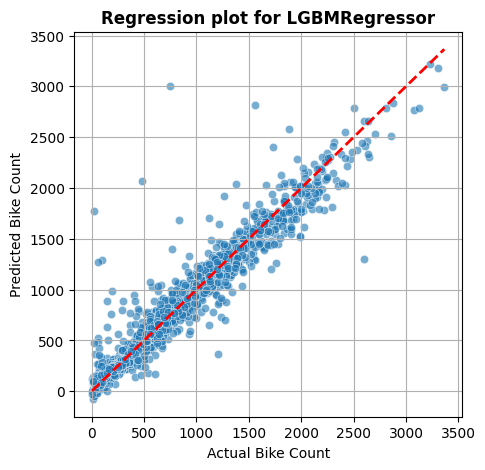

In [51]:
lgbm = LGBMRegressor()
lgbm.fit(X_train_scaled,y_train)
y_pred = lgbm.predict(X_test_scaled)
model_evaluation('LGBMRegressor',y_pred,save = True)

In [52]:
df_results = pd.DataFrame(results)
df_results = df_results.sort_values(by = 'R2_score',ascending = False).reset_index()
df_results['R2_score'] = df_results['R2_score'].round(3)
display(Markdown("===================== Model Results =====================\n" 
                 f"{df_results.to_markdown(index = False)}")) 

===================== Model Results =====================
|   index | Model                  |   R2_score |      MSE |      MAE |
|--------:|:-----------------------|-----------:|---------:|---------:|
|       6 | LGBMRegressor          |      0.929 |  27715.6 |  90.8425 |
|       5 | XGBRegressor           |      0.925 |  29261.2 |  96.8246 |
|       4 | RandomForestRegressor  |      0.923 |  30286.7 |  95.2458 |
|       3 | DecisionTreeRegression |      0.853 |  57795.2 | 133.997  |
|       2 | LassoRegression        |      0.574 | 167124   | 312.681  |
|       1 | RidgeRegression        |      0.573 | 167460   | 314.074  |
|       0 | LinearRegression       |      0.573 | 167482   | 314.128  |

In [53]:
fig = px.bar(
  df_results,
  x = 'R2_score',
  y = 'Model',
  title = "<b>Model Performance Comparison By R2 Score</b>",
  text = 'R2_score',
  color = 'Model'
)
fig.update_traces(
  textposition = 'outside'
)
fig.update_layout(
  title_x = 0.5,
  height = 600,
  width = 900,
  bargap = 0.25,
  plot_bgcolor = 'white',
  xaxis_title = 'R2 Score'
)
fig.show()

### **Best Models:**
- Here the LightGBM Regressor,XGB Regressor and RandomForestRegressor are the Top 3 Best models who perform better with each one near to 0.92 of accuracy
- We will tune those models to choose the Top Performing model by hyperparameter tuning and using GridSearchCV

## **15.Hyperparameter Tuning & Finding the Best Model**

In [54]:
pipelines = {
    'LightGBM': Pipeline([
        ('preprocessor', preprocessor),
        ('model', LGBMRegressor(random_state=42, verbose=-1))
    ]),
    
    'XGBoost': Pipeline([
        ('preprocessor', preprocessor),
        ('model', XGBRegressor(random_state=42))
    ]),
    
    'RandomForest': Pipeline([
        ('preprocessor', preprocessor),
        ('model', RandomForestRegressor(random_state=42))
    ])
}

In [55]:
param_grids = {
    'LightGBM': {
        'model__n_estimators': [200, 500],
        'model__learning_rate': [0.05, 0.1],
        'model__num_leaves': [31, 50]
    },
    
    'XGBoost': {
        'model__n_estimators': [200, 500],
        'model__learning_rate': [0.05, 0.1],
        'model__max_depth': [3, 5]
    },
    
    'RandomForest': {
        'model__n_estimators': [100, 200],
        'model__max_depth': [10, 20],
        'model__max_features': ['sqrt', 'log2']
    }
}

In [56]:
best_models = {}
model_results = []

for name, pipeline in pipelines.items():
    print(f"************ Tuning {name} ************")
    
    # Create GridSearchCV
    grid = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grids[name],
        cv=3,
        scoring='r2',
        verbose=1,
        n_jobs=-1 # Use all CPU cores
    )
    
    # Fit (Note: Pass X_train, NOT X_train_scaled. The pipeline handles scaling!)
    grid.fit(X_train, y_train)
    
    # Save the best
    print(f"Best Score (CV R2): {grid.best_score_:.4f}")
    print(f"Best Params: {grid.best_params_}\n")
    best_models[name] = grid.best_estimator_

    model_results.append({
        "Model":name,
        "Best Parameters":grid.best_params_,
        "R2 Score":grid.best_score_
    })

    # Save each tuned model
    joblib.dump(best_models, f"best_{name.replace(' ', '_')}.pkl")
    print(f" Saved model as best_{name.replace(' ', '_')}.pkl")


print("Tuning Complete!")

************ Tuning LightGBM ************
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best Score (CV R2): 0.9482
Best Params: {'model__learning_rate': 0.05, 'model__n_estimators': 500, 'model__num_leaves': 50}

 Saved model as best_LightGBM.pkl
************ Tuning XGBoost ************
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best Score (CV R2): 0.9428
Best Params: {'model__learning_rate': 0.1, 'model__max_depth': 5, 'model__n_estimators': 500}

 Saved model as best_XGBoost.pkl
************ Tuning RandomForest ************
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best Score (CV R2): 0.9166
Best Params: {'model__max_depth': 20, 'model__max_features': 'sqrt', 'model__n_estimators': 200}

 Saved model as best_RandomForest.pkl
Tuning Complete!


==============LightGBM==============
R2_score: 0.9353005419313021
MSE: 25400.12489472949
MAE: 80.90360807276241



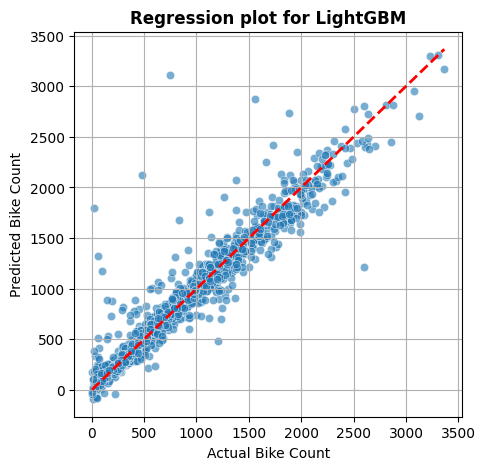

In [57]:
# evaluate the best model
best_model = best_models['LightGBM']
y_pred_final = best_model.predict(X_test) # pipeline will handle the scaling

model_evaluation('LightGBM',y_pred_final)

In [58]:
results_df = pd.DataFrame(model_results)
results_df = results_df.sort_values(by = "R2 Score",ascending=False).reset_index(drop=True)
display(Markdown("### <b>Best Models Tuned Results</b>\n"f"{results_df.to_markdown(index=False)}"))

### <b>Best Models Tuned Results</b>
| Model        | Best Parameters                                                                     |   R2 Score |
|:-------------|:------------------------------------------------------------------------------------|-----------:|
| LightGBM     | {'model__learning_rate': 0.05, 'model__n_estimators': 500, 'model__num_leaves': 50} |   0.948158 |
| XGBoost      | {'model__learning_rate': 0.1, 'model__max_depth': 5, 'model__n_estimators': 500}    |   0.942791 |
| RandomForest | {'model__max_depth': 20, 'model__max_features': 'sqrt', 'model__n_estimators': 200} |   0.916648 |

## **Best Models Comparison**

In [59]:
fig = px.bar(
    model_results,
    x='Model',
    y='R2 Score',
    color='Model',
    title="<b>Best Models Performance Comparison</b>",
    text='R2 Score'
)

fig.update_traces(texttemplate='%{text:.3f}', textposition='outside')

fig.update_layout(
    title_x=0.5,
    xaxis_title='<b>Model</b>',
    yaxis_title='<b>R2 Score</b>',
    width = 700,
    height=500,
    bargap=0.25,
    legend_title_text='<b>Models</b>'
)

fig.show()

## **Best Final Model => LightGBM** with r2 score of 0.9481 over the **training data** and r2 score of 0.9353 over **test data** and this shows that Our best performing model is LightGBM and it does not overfits.

## **16.Shap Interpretability For LightGBM**

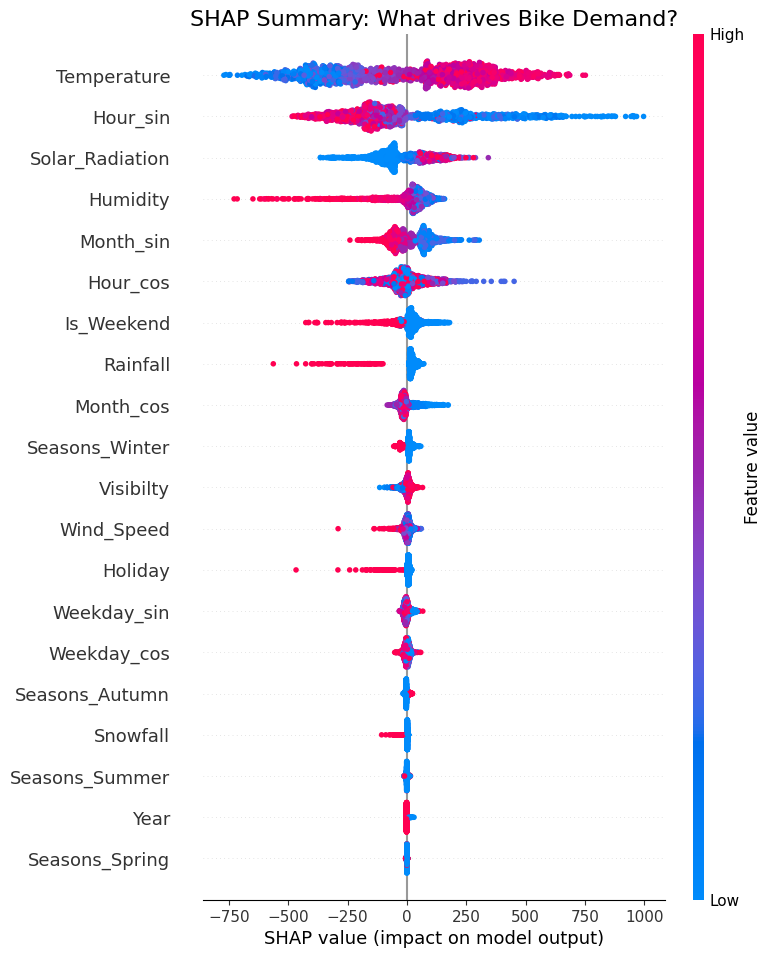

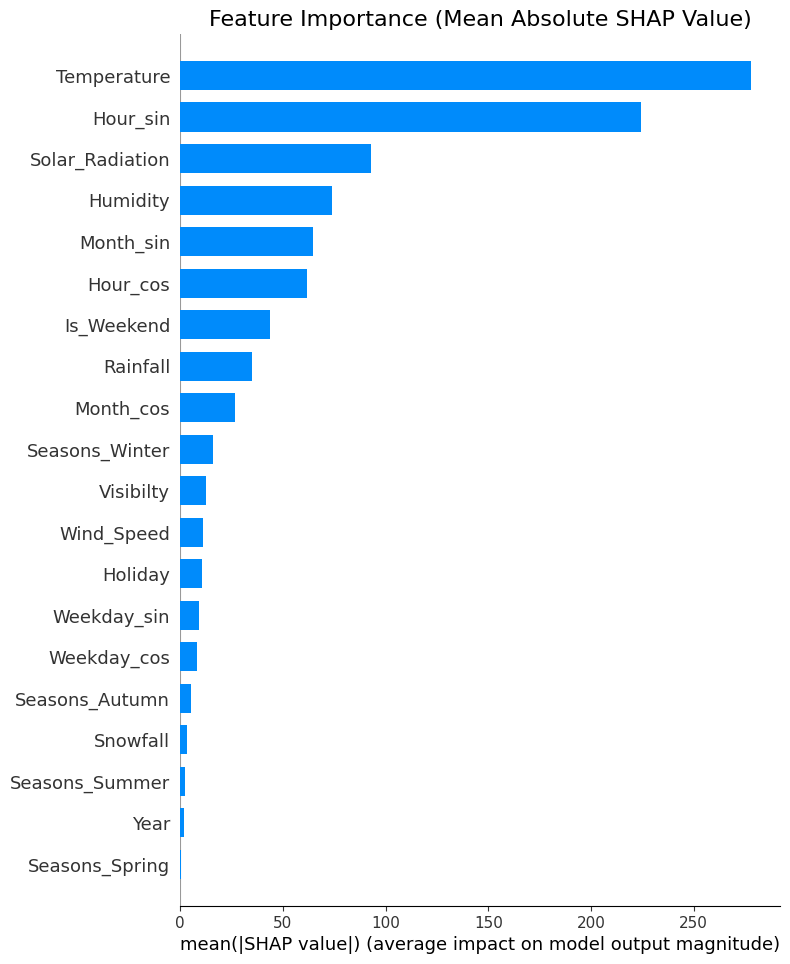

In [72]:
import shap

#extracting the pipeline from the model
pipeline = best_models['LightGBM']
lgbm_model = pipeline.named_steps['model']
preprocessor = pipeline.named_steps['preprocessor']

# scaling the X_test for shap
X_test_transformed = preprocessor.transform(X_test)

# We extract names from the column transformer so the plot says "Temperature" instead of "Feature_0"
feature_names = preprocessor.get_feature_names_out()

# Clean up names (remove 'num__' and 'cat__' prefixes for better visuals)
clean_feature_names = [name.split('__')[1] for name in feature_names]

# Create a DataFrame for SHAP (easier to handle than numpy array)
X_test_shap_df = pd.DataFrame(X_test_transformed, columns=clean_feature_names)

# LightGBM is a tree-based model, so we use TreeExplainer which is faster
explainer = shap.TreeExplainer(lgbm_model)
shap_values = explainer.shap_values(X_test_shap_df)

#summary plot
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_test_shap_df, show=False)
plt.title('SHAP Summary: What drives Bike Demand?', fontsize=16)
plt.show()

#bar plot
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_test_shap_df, plot_type="bar", show=False)
plt.title('Feature Importance (Mean Absolute SHAP Value)', fontsize=16)
plt.show()


**SHAP Summary Plot**
- Temperature dominates: warmer conditions sharply increase bike demand, cold weather suppresses it.

- Time-of-day patterns (Hour_sin/cos) strongly shape demand, with clear rush-hour peaks.

- Solar radiation boosts usage, while humidity and rainfall consistently drag demand down.

- Weekends reduce predicted demand, showing a commuter-driven pattern.

- Most season one-hot features add little influence compared to cyclical encodings.

**Mean Absolute SHAP Bar Plot**

- Temperature is the single most impactful feature by a wide margin.

- Hour_sin and Solar_Radiation follow as major global drivers of predictions.

- Humidity, Month_sin, and Hour_cos hold moderate but meaningful influence.

- Rainfall and Is_Weekend contribute smaller yet noticeable effects.

- Seasonal one-hot features, Year, and Snowfall have minimal importance and could be simplified away.

# **<u>Final Project Summary & Recommendations</u>**

## **1. Model Performance Overview**
#### After testing seven different models—from simple linear baselines to more advanced ensemble methods—LightGBM ended up delivering the best results. It reached an R² of 93.5% on the test set and showed very little overfitting (94.8% train vs. 93.5% test), which means it captured real patterns in how people use the bike system. Unlike Linear Regression, which struggled with non-linear patterns like rush-hour spikes, LightGBM handled those interactions well, especially temperature effects where demand drops at both very cold and very hot extremes.

## **2. Key Insights from SHAP Analysis**

### SHAP helped uncover what actually drives bike demand.

- #### Time of day is the strongest factor. Demand follows a clear commuter rhythm, with sharp peaks around 8 AM and 6 PM.
- #### Weather has a major influence. Temperature increases demand up to about 25°C, then levels off or declines. Even light rain causes demand to crash almost instantly.
- #### Seasonality matters too. Usage climbs during summer and falls sharply in winter, particularly when temperatures drop below freezing.

## **3. Business Recommendations**

### Based on the model’s findings, several operational improvements stand out:
- #### Smarter Inventory Rebalancing: Move bikes proactively about an hour before peak commuting times. Morning focus should be on stocking residential areas; evenings should prioritize office districts to avoid empty stations and missed revenue.
- #### Weather-Aligned Maintenance: Use rainy days and winter downtime for repairs and servicing, since demand is naturally low during these periods.
- #### Dynamic Pricing: Offer discounts during mid-day off-peak hours (10 AM–4 PM) to attract leisure riders and improve overall system usage.

## **4. Future Enhancements**
### To push accuracy even further, future iterations could:
- #### Automatically integrate public holiday data.
- #### Incorporate real-time traffic conditions, since bike usage rises when roads are congested.
- #### Explore deep learning approaches like LSTMs to better capture time-dependent patterns.

## **<u>Conclusion</u>**
#### The project shows that bike-sharing demand is highly predictable. With a strong model like LightGBM, the system can shift from reacting to empty stations to anticipating them—leading to smoother operations and lower costs.